<a href="https://colab.research.google.com/github/wildanputra/deeplearningtutorial/blob/master/surface_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surface defect detection

sources inspiration:
https://towardsdatascience.com/deep-learning-computer-vision-and-automated-optical-inspection-774e8ca529d3

dataset : http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html

in this case we will use 2 different method transfer learning for the classification, we will use pre-training & fine tuning with inception v3 model.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


# Preprocessing
### Download data surface defect

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
folder_loc = 'gdrive/My Drive/colab notebook/NEU-CLS-64'
base_dir, _ = os.path.splitext(folder_loc)

In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# --------- Train --------------
# Directory with our train rs datasets
train_rs_dir = os.path.join(train_dir, 'rs')
print ('Total training rs images:', len(os.listdir(train_rs_dir)))

# Directory with our train pa datasets
train_pa_dir = os.path.join(train_dir, 'pa')
print ('Total training pa images:', len(os.listdir(train_pa_dir)))

# Directory with our train cr datasets
train_cr_dir = os.path.join(train_dir, 'cr')
print ('Total training cr images:', len(os.listdir(train_cr_dir)))

# Directory with our train ps datasets
train_ps_dir = os.path.join(train_dir, 'ps')
print ('Total training ps images:', len(os.listdir(train_ps_dir)))

# Directory with our train in datasets
train_in_dir = os.path.join(train_dir, 'in')
print ('Total training in images:', len(os.listdir(train_in_dir)))

# Directory with our train sc datasets
train_sc_dir = os.path.join(train_dir, 'sc')
print ('Total training sc images:', len(os.listdir(train_sc_dir)))

# Directory with our train sp datasets
train_sp_dir = os.path.join(train_dir, 'sp')
print ('Total training sp images:', len(os.listdir(train_sp_dir)))

# Directory with our train rp datasets
train_rp_dir = os.path.join(train_dir, 'rp')
print ('Total training rp images:', len(os.listdir(train_rp_dir)))

# Directory with our train gg datasets
train_gg_dir = os.path.join(train_dir, 'gg')
print ('Total training gg images:', len(os.listdir(train_gg_dir)))

# --------- Validation --------------

# Directory with our validation rs datasets
validation_rs_dir = os.path.join(validation_dir, 'rs')
print ('Total validation rs images:', len(os.listdir(validation_rs_dir)))

# Directory with our validation pa datasets
validation_pa_dir = os.path.join(validation_dir, 'pa')
print ('Total validation pa images:', len(os.listdir(validation_pa_dir)))

# Directory with our validation cr datasets
validation_cr_dir = os.path.join(validation_dir, 'cr')
print ('Total validation cr images:', len(os.listdir(validation_cr_dir)))

# Directory with our validation ps datasets
validation_ps_dir = os.path.join(validation_dir, 'ps')
print ('Total validation ps images:', len(os.listdir(validation_ps_dir)))

# Directory with our validation in datasets
validation_in_dir = os.path.join(validation_dir, 'in')
print ('Total validation in images:', len(os.listdir(validation_in_dir)))

# Directory with our validation sc datasets
validation_sc_dir = os.path.join(validation_dir, 'sc')
print ('Total validation sc images:', len(os.listdir(validation_sc_dir)))

# Directory with our validation sp datasets
validation_sp_dir = os.path.join(validation_dir, 'sp')
print ('Total validation sp images:', len(os.listdir(validation_sp_dir)))

# Directory with our validation rp datasets
validation_rp_dir = os.path.join(validation_dir, 'rp')
print ('Total validation rp images:', len(os.listdir(validation_rp_dir)))

# Directory with our validation gg datasets
validation_gg_dir = os.path.join(validation_dir, 'gg')
print ('Total validation gg images:', len(os.listdir(validation_gg_dir)))

Total training rs images: 175
Total training pa images: 175
Total training cr images: 175
Total training ps images: 175
Total training in images: 175
Total training sc images: 175
Total training sp images: 175
Total training rp images: 175
Total training gg images: 175
Total validation rs images: 25
Total validation pa images: 25
Total validation cr images: 25
Total validation ps images: 25
Total validation in images: 25
Total validation sc images: 25
Total validation sp images: 25
Total validation rp images: 25
Total validation gg images: 25


### Create Image Data Generator with Image Augmentation
We will use ImageDataGenerator to rescale the images.

To create the train generator, specify where the train dataset directory, image size, batch size and binary classification mode.

The validation generator is created the same way.

In [18]:
image_size = 224 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use categorical loss, we need binary labels
                class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 1575 images belonging to 9 classes.
Found 225 images belonging to 9 classes.


# Create the base model from inception v3 model

# Fine Tuning

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model inception V3
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=IMG_SHAPE)

## Un-freeze all layers of the model

In [56]:
base_model.trainable = True

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 111, 111, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 111, 111, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

## Compile the model
Compile the model using a much-lower training rate.

In [0]:
model_fine = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(9, activation='softmax')
  ])

In [0]:
model_fine.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model_fine.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 4617      
Total params: 22,856,489
Trainable params: 22,822,057
Non-trainable params: 34,432
_________________________________________________________________


In [52]:
len(model_fine.trainable_variables)

192

In [53]:
epochs = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history_fine = model_fine.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/20
49/49 [==============================] - 42s 854ms/step - loss: 1.1714 - acc: 0.6286 - val_loss: 38.0296 - val_acc: 0.1116
Epoch 2/20
49/49 [==============================] - 17s 355ms/step - loss: 0.7854 - acc: 0.7485 - val_loss: 37.0858 - val_acc: 0.1562
Epoch 3/20
49/49 [==============================] - 18s 360ms/step - loss: 0.5575 - acc: 0.8061 - val_loss: 3.7524 - val_acc: 0.5714
Epoch 4/20
49/49 [==============================] - 17s 356ms/step - loss: 0.4869 - acc: 0.8267 - val_loss: 1.9985 - val_acc: 0.5670
Epoch 5/20
49/49 [==============================] - 18s 358ms/step - loss: 0.4971 - acc: 0.8308 - val_loss: 0.8897 - val_acc: 0.7366
Epoch 6/20
49/49 [==============================] - 18s 360ms/step - loss: 0.4188 - acc: 0.8380 - val_loss: 2.3992 - val_acc: 0.5804
Epoch 7/20
49/49 [==============================] - 18s 358ms/step - loss: 0.4201 - acc: 0.8607 - val_loss: 1.1166 - val_acc: 0.7366
Epoch 8/20
49/49 [==============================] - 18s 359ms/step 

## Learning curves
Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the Inception V3 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting.

Note: the training dataset is fairly small, and is similar to the original datasets that Inception V3 was trained on, so fine-tuning may result in **overfitting**.

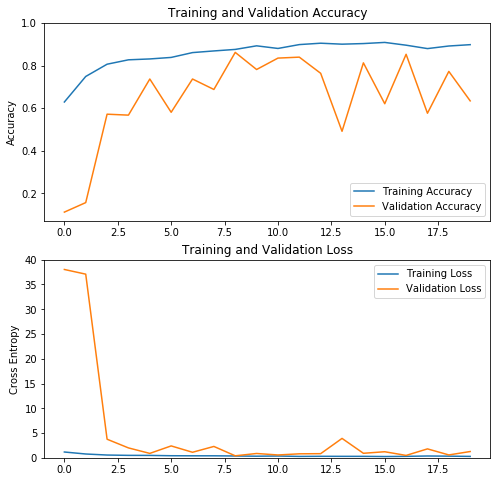

In [54]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()